# SD6125 Technical Review (Jo)

## Overview
### Dataset
source: https://archive.ics.uci.edu/dataset/292/wholesale+customers  
The data set refers to clients of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on diverse product categories.  
There are 7 features: 'Channel', 'Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper' 'Delicassen' and 1 target: 'Region'.  

1)	FRESH: annual spending (m.u.) on fresh products (Continuous);
2)	MILK: annual spending (m.u.) on milk products (Continuous);
3)	GROCERY: annual spending (m.u.)on grocery products (Continuous);
4)	FROZEN: annual spending (m.u.)on frozen products (Continuous);
5)	DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous);
6)	DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous); 
7)	CHANNEL: customersâ€™ Channel - Horeca (Hotel/Restaurant/CafÃ©) or Retail channel (Nominal);
8)	REGION: customersâ€™ Region â€“ Lisnon, Oporto or Otminal) (Nominal);

### Decomposition methods evaluated:
1) PCA
2) t-SNE

### Clustering methods evaluated:
1) k-means  
2) Hierarchical clustering  
3) DBScan  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics

# dataset
# pip install ucimlrepo
from ucimlrepo import fetch_ucirepo 

# dimensionality reduction methods
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# clustering methods
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN


In [2]:
# fetch dataset 
wholesale_customers = fetch_ucirepo(id=292) 
  
# variable information 
info = wholesale_customers.variables
print("Variable info: ")
display(info)
        
# data
X = wholesale_customers.data.features.rename(columns={'Detergents_Paper': 'Det_Paper', 'Delicassen': 'Deli'}) # shorten names 
print("Features shape: ", X.shape)
# Notes: Channel is categorical
display(X.describe())

y = wholesale_customers.data.targets 
print("Target shape: ", y.shape)

Variable info: 


,name,role,type,demographic,description,units,missing_values
0,Channel,Feature,Categorical,None,None,None,no
1,Region,Target,Categorical,None,None,None,no
2,Fresh,Feature,Integer,None,None,None,no
3,Milk,Feature,Integer,None,None,None,no
4,Grocery,Feature,Integer,None,None,None,no
5,Frozen,Feature,Integer,None,None,None,no
6,Detergents_Paper,Feature,Integer,None,None,None,no
7,Delicassen,Feature,Integer,None,None,None,no


Features shape:  (440, 7)


,Channel,Fresh,Milk,Grocery,Frozen,Det_Paper,Deli
count,440.00,440.00,440.00,440.00,440.00,440.00,440.00
mean,1.32,12000.30,5796.27,7951.28,3071.93,2881.49,1524.87
std,0.47,12647.33,7380.38,9503.16,4854.67,4767.85,2820.11
min,1.00,3.00,55.00,3.00,25.00,3.00,3.00
25%,1.00,3127.75,1533.00,2153.00,742.25,256.75,408.25
50%,1.00,8504.00,3627.00,4755.50,1526.00,816.50,965.50
75%,2.00,16933.75,7190.25,10655.75,3554.25,3922.00,1820.25
max,2.00,112151.00,73498.00,92780.00,60869.00,40827.00,47943.00


Target shape:  (440, 1)


# Frequency distribution of features

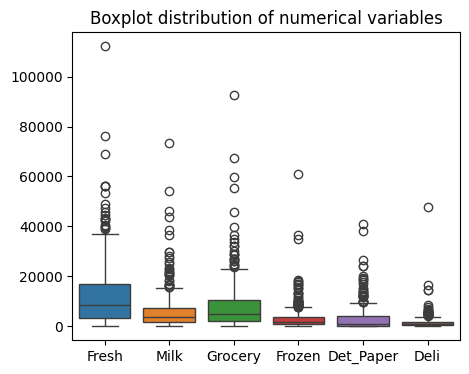

In [3]:
plt.figure(figsize=(5, 4))
sns.boxplot(data=X.drop(['Channel'], axis=1))
plt.title('Boxplot distribution of numerical variables')
plt.show()

- Less is spent on Deli as compared to the others

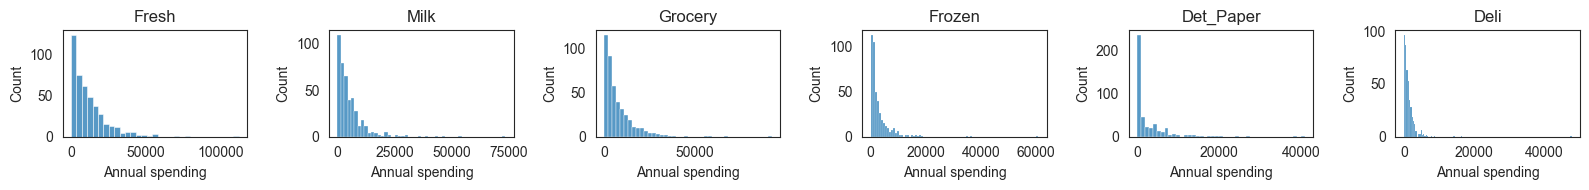

In [4]:
sns.set_style(style='white')
fig, axes = plt.subplots(1, len(X.columns)-1, figsize=(16, 2))
axes = axes.flatten()

for i, col in enumerate(X.iloc[:,1:].columns):
    sns.histplot(x=X[col], ax=axes[i])
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Annual spending')

plt.tight_layout()
plt.show()

- Det_Paper has unusually high frequency counts of lower spendings

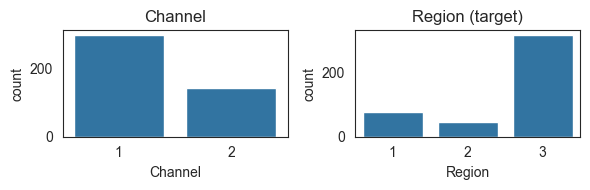

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(6, 2))

sns.countplot(data=X, x='Channel', ax=axes[0])
axes[0].set_title('Channel')

sns.countplot(data=y, x='Region', ax=axes[1])
axes[1].set_title('Region (target)')

plt.tight_layout()
plt.show()

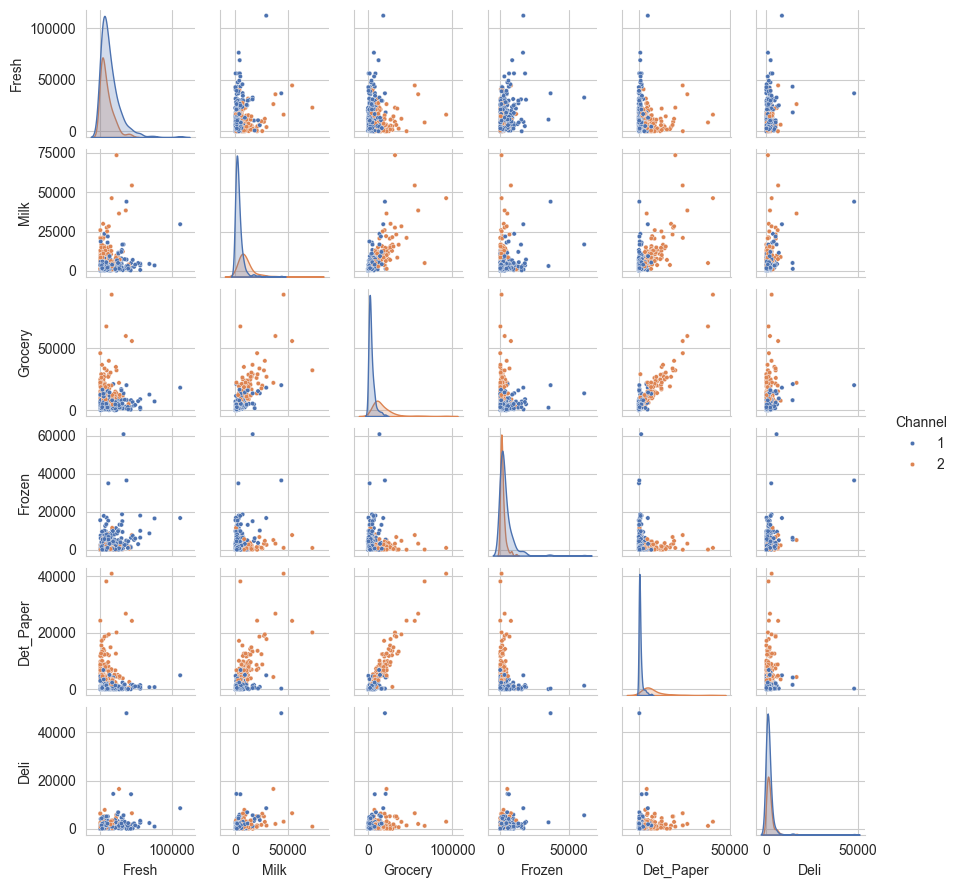

In [6]:
# scatterplot to show relationship of numerical variables against each other, and to visualize the distribution of the variables
sns.set_style(style='whitegrid')
with sns.plotting_context(rc={"axes.labelsize":10}):
    sns.pairplot(X, height = 1.5, plot_kws={"s": 10}, hue="Channel", palette="deep")
    plt.show();

- features are right skewed, indicating that there are some outliers that are high spenders  
- Channel 2 tends to purchase more Milk, Grocery, and Det_Paper

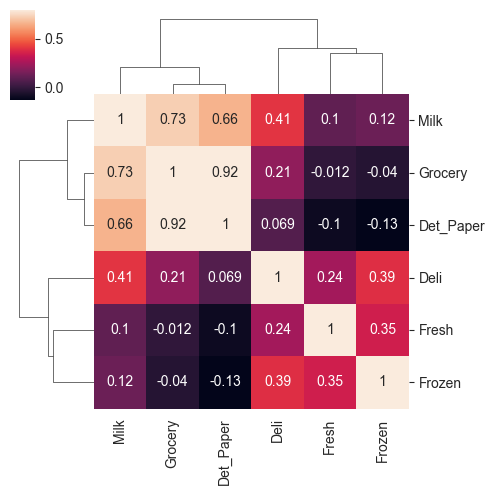

In [7]:
# correlation matrix
corrmat = X.iloc[:,1:].corr()
sns.clustermap(corrmat, vmax=.8, figsize = (5, 5), annot=True);

- strong positive correlation between Grocery and Det_Paper, clients who spend more on groceries also tend to spend on detergents and paper (0.92)
- Milk also shows a positive correlation with Grocery and Det_Paper (0.73, 0.66)
- Deli do not show as strong a correlation with other variables, which might indicate that it is independent of other variables

# Dimensionality reduction with PCA

,Features,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,Channel,0.43,-0.21,0.02,-0.09,-0.86,0.13,0.02
1,Fresh,-0.03,0.51,-0.81,-0.25,-0.13,-0.03,-0.03
2,Milk,0.47,0.21,0.06,-0.06,0.32,0.79,-0.04
3,Grocery,0.54,-0.01,-0.11,0.13,0.21,-0.35,0.72
4,Frozen,-0.03,0.59,0.18,0.75,-0.23,-0.00,-0.01
5,Det_Paper,0.52,-0.12,-0.14,0.20,0.19,-0.37,-0.69
6,Deli,0.16,0.53,0.53,-0.56,-0.03,-0.31,-0.08


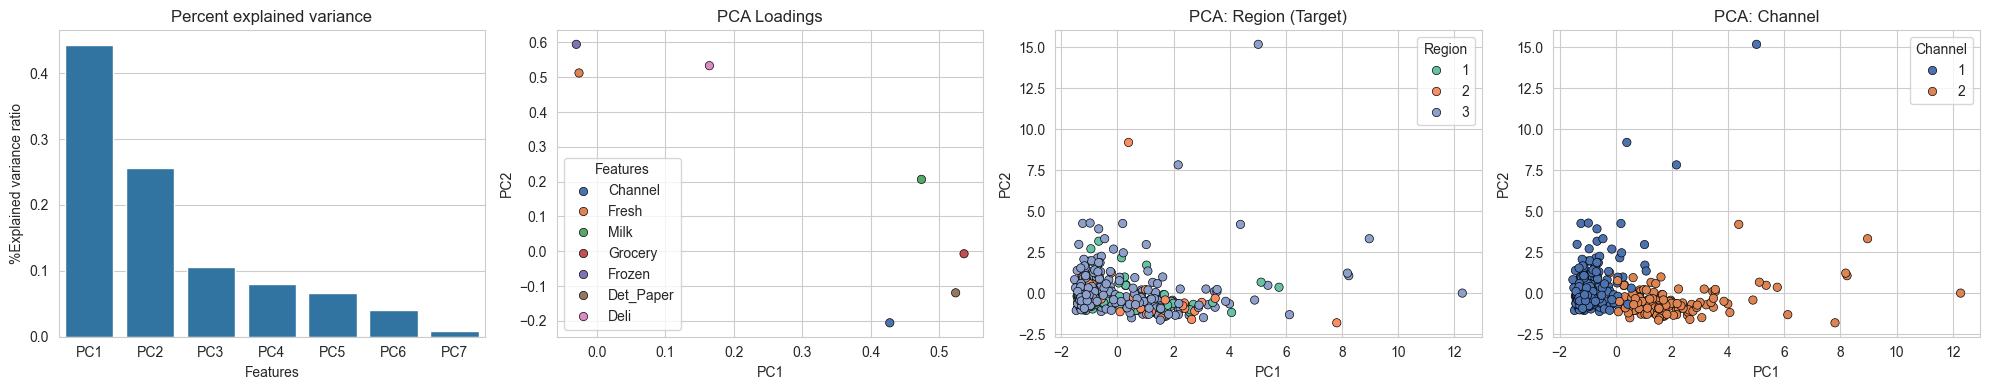

In [8]:
np.random.seed(42)
pca = PCA()

# scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca_X = pd.DataFrame(pca.fit_transform(X_scaled), columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'])
var = pca.explained_variance_ratio_
feature_name = list(X.columns)

# relationship between features (loadings) and components
pca_loadings = pd.DataFrame({ 'Features':list(X.columns),'PC1':pca.components_[0],'PC2':pca.components_[1],'PC3':pca.components_[2],
                          'PC4':pca.components_[3],'PC5':pca.components_[4], 'PC6':pca.components_[5], 'PC7':pca.components_[6]})
display(pca_loadings)

# subplots with 1 row and 4 columns
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
sns.barplot(x=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'], y=var, ax=axes[0])
axes[0].set_title('Percent explained variance')
axes[0].set_xlabel("Features")
axes[0].set_ylabel("%Explained variance ratio")

sns.scatterplot(pca_loadings, x="PC1", y="PC2", hue="Features", palette="deep", edgecolor='black', ax=axes[1])
axes[1].set_title('PCA Loadings')

sns.scatterplot(pca_X, x="PC1", y="PC2", hue = y.squeeze(), palette='Set2', edgecolor = 'black', ax=axes[2])
axes[2].set_title('PCA: Region (Target)')

sns.scatterplot(pca_X, x="PC1", y="PC2", hue = X['Channel'], palette="deep", edgecolor='black', ax=axes[3])
axes[3].set_title('PCA: Channel')

plt.tight_layout()
plt.show()

- The first 3 PCs explains > 75% of the variance in the data (1st plot)
- The main features that drive the separation between PC1 and PC2 are {Fresh, Frozen, Deli} vs Others. Fresh and Frozen are closer together than Deli (2nd plot)
- The variance captured by the first two PCs is not effectively separating the clients by Region (3rd plot)
- PC1 captures the variance that is most discriminative for the Channel feature (4th plot)
- It is likely that linear PCA decomposition with 2 PCs may be insuffient to distinguish the Regions
- The first 3 PCs are chosen for the subsequent analysis as it captures >75% of the variance

# Dimensionality reduction with t-SNE

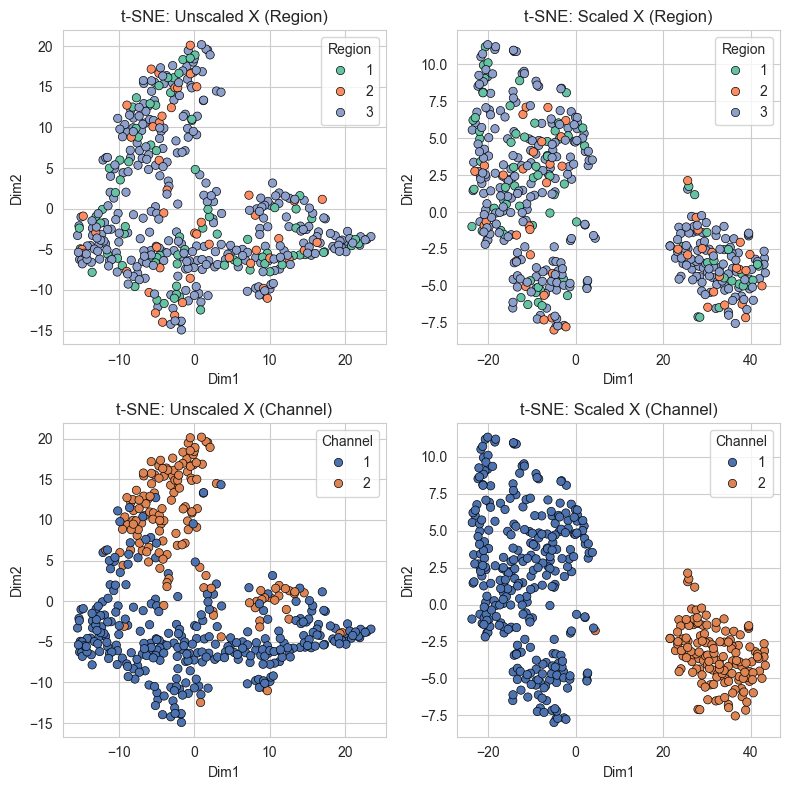

In [9]:
# t-SNE for unscaled X
tsne = TSNE(random_state=42, perplexity = 40)  # default
tsne_X_unscaled = pd.DataFrame(tsne.fit_transform(X), columns=['Dim1', 'Dim2'])
# t-SNE for scaled X
tsne_X_scaled = pd.DataFrame(tsne.fit_transform(X_scaled), columns=['Dim1', 'Dim2'])

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

sns.scatterplot(data=tsne_X_unscaled, x="Dim1", y="Dim2", hue=y.squeeze(), palette="Set2", ax=axes[0,0], edgecolor='black')
axes[0,0].set_title('t-SNE: Unscaled X (Region)')

sns.scatterplot(data=tsne_X_scaled, x="Dim1", y="Dim2", hue=y.squeeze(), palette="Set2", ax=axes[0,1], edgecolor='black')
axes[0,1].set_title('t-SNE: Scaled X (Region)')

sns.scatterplot(data=tsne_X_unscaled, x="Dim1", y="Dim2", hue=X['Channel'], palette="deep", ax=axes[1,0], edgecolor='black')
axes[1,0].set_title('t-SNE: Unscaled X (Channel)')

sns.scatterplot(data=tsne_X_scaled, x="Dim1", y="Dim2", hue=X['Channel'], palette="deep", ax=axes[1,1], edgecolor='black')
axes[1,1].set_title('t-SNE: Scaled X (Channel)')

plt.tight_layout()
plt.show()

- scaling helps in separating the data into two Channel clusters
- t-SNE results suggest that the Channels could be driven by relationships that are non-linearly separable
- again, there is no clear separation between the Regions, suggesting that the available features may not be sufficient in distinguishing between the Regions  

## t-SNE parameters

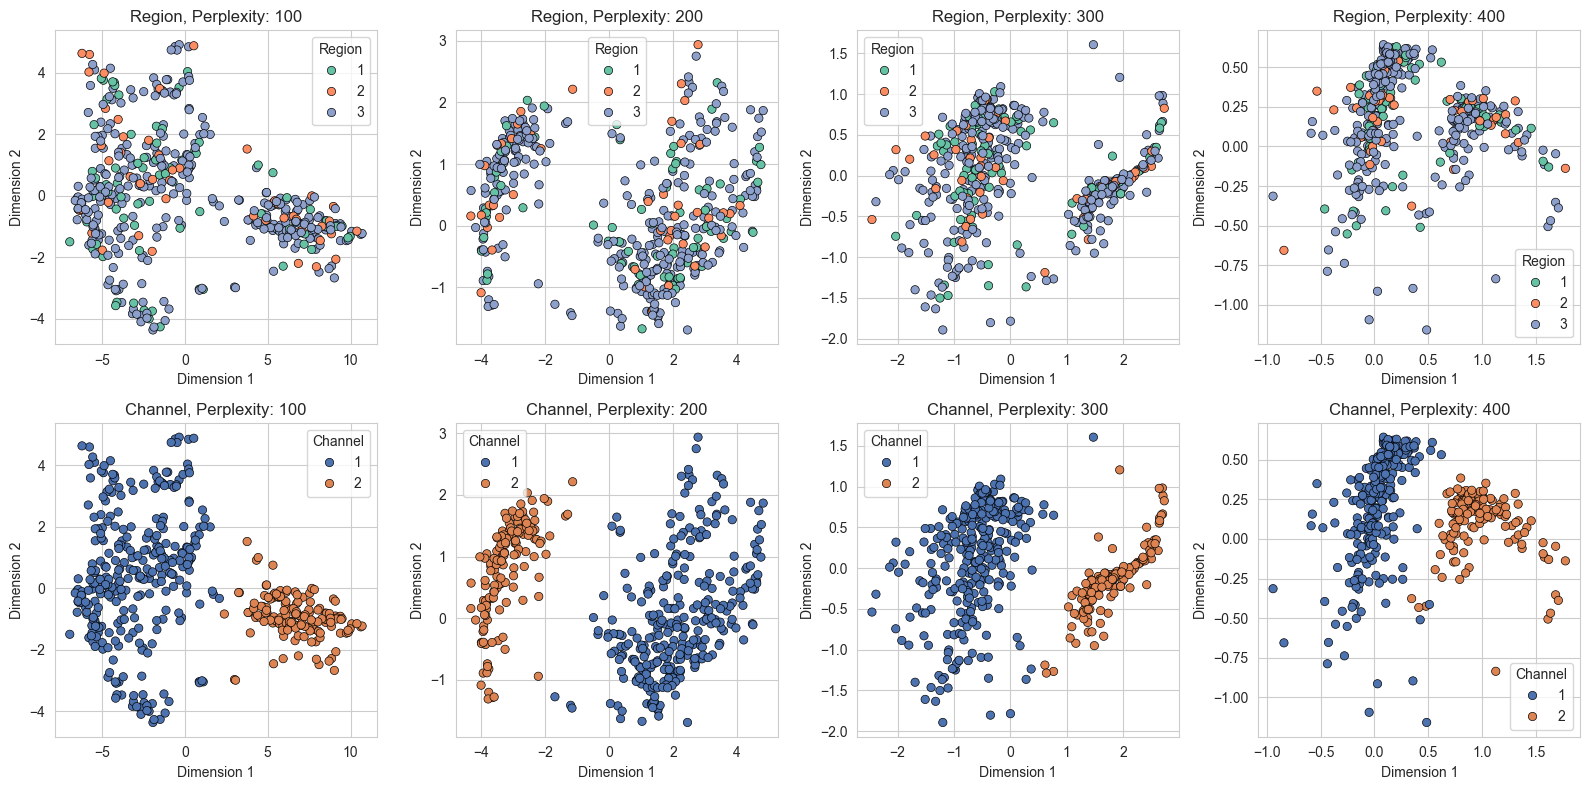

In [10]:
perplexities = [100, 200, 300, 400]
fig, axes = plt.subplots(2, len(perplexities), figsize=(16, 8))

for i, perplexity in enumerate(perplexities):
    
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=300, random_state=42)
    tsne_X_scaled = pd.DataFrame(tsne.fit_transform(X_scaled), columns=['Dim1', 'Dim2'])

    ax = axes[0,i]
    sns.scatterplot(data=tsne_X_scaled, x="Dim1", y="Dim2", hue=y.squeeze(), palette="Set2", ax=ax, edgecolor='black').set_title(f'Region, Perplexity: {perplexity}')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')

    ax = axes[1,i]
    sns.scatterplot(data=tsne_X_scaled, x="Dim1", y="Dim2", hue=X['Channel'], palette="deep", ax=ax, edgecolor='black').set_title(f'Channel, Perplexity: {perplexity}')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')

plt.tight_layout()
plt.show()

- perplexity of 100 should work well for k-means clustering as the points are closer to centroids  
- perplexity of 200 separate clusters well, but note some Channel 2 points being closer to Channel 1 when clustering points by density-based methods
- perplexity of 300 onwards result in tighter clusters, but there are more outlier points which may distort centroids (when using k-means) or become outliers in density-based methods
- adjusting perplexity does not help in identifying Region
- Note: Neither distances nor density are preserved in t-SNE!

In [11]:
# construct selected t-sne params
tsne = TSNE(n_components=2, perplexity=100, n_iter=300, random_state=42)
tsne_X_scaled_p100 = pd.DataFrame(tsne.fit_transform(X_scaled), columns=['Dim1', 'Dim2'])
tsne = TSNE(n_components=2, perplexity=200, n_iter=300, random_state=42)
tsne_X_scaled_p200 = pd.DataFrame(tsne.fit_transform(X_scaled), columns=['Dim1', 'Dim2'])

# Clustering method: K-means

## Determine optimal clusters with Silhouette method 

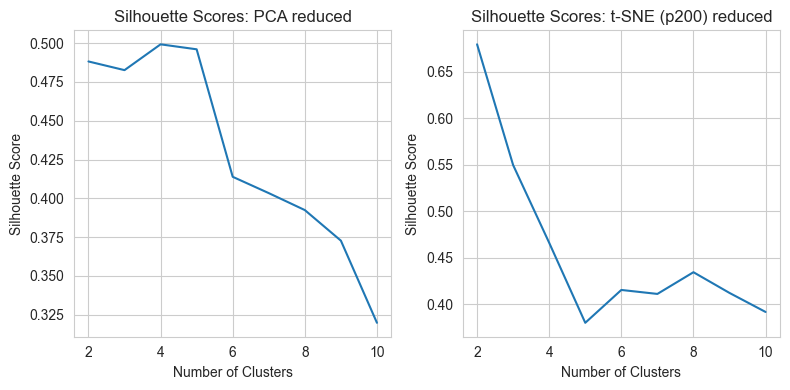

Best k for PCA data =  4 ; Silhouette Score:  0.499
Best k for t-SNE (p200) data =  2 ; Silhouette Score:  0.679


In [12]:
ss_pca = []; ss_tsne = []; kmax = 10

# choose top 3 components as it represents > 75% of variance
pca_X_final = pca_X.iloc[:,:3]

for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters = k, random_state = 42).fit(pca_X_final)
    labels = kmeans.labels_
    ss_pca.append(silhouette_score(pca_X_final, labels, metric = 'euclidean'))

    kmeans = KMeans(n_clusters = k, random_state = 42).fit(tsne_X_scaled_p200)
    labels = kmeans.labels_
    ss_tsne.append(silhouette_score(tsne_X_scaled_p200, labels, metric = 'euclidean'))

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax = axes[0]
sns.lineplot(x = range(2,kmax + 1), y = ss_pca, ax=ax)
ax.set_title('Silhouette Scores: PCA reduced')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Silhouette Score")

ax = axes[1]
sns.lineplot(x = range(2,kmax + 1), y = ss_tsne, ax=ax)
ax.set_title('Silhouette Scores: t-SNE (p200) reduced') # p100 should have similar number of clusters
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Silhouette Score")

plt.tight_layout()
plt.show()

k_pca = ss_pca.index(max(ss_pca)) + 2
print("Best k for PCA data = ", k_pca, "; Silhouette Score: ", round(max(ss_pca), 3))

k_tsne = ss_tsne.index(max(ss_tsne)) + 2
print("Best k for t-SNE (p200) data = ", k_tsne, "; Silhouette Score: ", round(max(ss_tsne), 3))

# K-means clustering

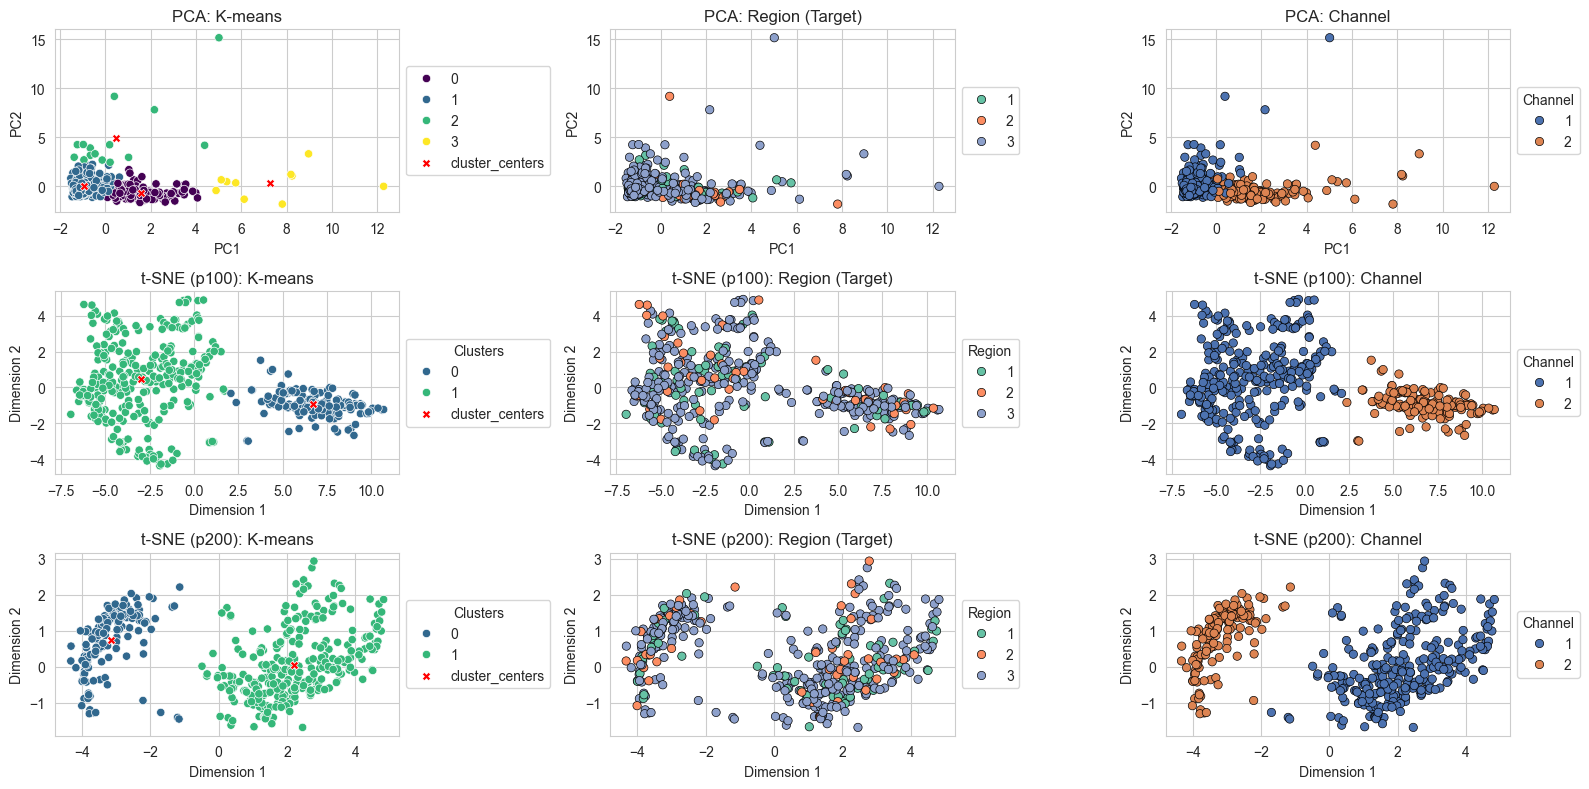

In [13]:
model = KMeans(n_clusters=k_pca, max_iter=1000, random_state=42)
model.fit(pca_X_final)
cluster_centers_pca = model.cluster_centers_
labels_pca = model.labels_

model = KMeans(n_clusters=k_tsne, max_iter=1000, random_state=42)
model.fit(tsne_X_scaled_p100)
cluster_centers_tsne100 = model.cluster_centers_
labels_tsne100 = model.labels_

model = KMeans(n_clusters=k_tsne, max_iter=1000, random_state=42)
model.fit(tsne_X_scaled_p200)
cluster_centers_tsne = model.cluster_centers_
labels_tsne = model.labels_

fig, axes = plt.subplots(3, 3, figsize=(16, 8))

# Plot the embedded data
ax = axes[0,0]
sns.scatterplot(pca_X_final, x="PC1", y="PC2", hue=labels_pca, palette='viridis', ax=ax)
sns.scatterplot(x = cluster_centers_pca[:, 0], y = cluster_centers_pca[:, 1], color='red', label='cluster_centers', marker='X', ax=ax)
ax.set_title('PCA: K-means')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax = axes[0,1]
sns.scatterplot(pca_X_final, x="PC1", y="PC2", hue = y.squeeze(), palette='Set2', edgecolor = 'black', ax=ax)
ax.set_title('PCA: Region (Target)')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax = axes[0,2]
sns.scatterplot(pca_X_final, x="PC1", y="PC2", hue = X['Channel'], palette="deep", edgecolor='black', ax=ax)
ax.set_title('PCA: Channel')
ax.legend(title = 'Channel', loc='center left', bbox_to_anchor=(1, 0.5))

ax = axes[1,0]
sns.scatterplot(tsne_X_scaled_p100, x="Dim1", y="Dim2", hue=labels_tsne100, palette='viridis', ax=ax)
sns.scatterplot(x = cluster_centers_tsne100[:, 0], y = cluster_centers_tsne100[:, 1], color='red', label='cluster_centers', marker='X', ax=ax)
ax.set_title('t-SNE (p100): K-means')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.legend(title = 'Clusters', loc='center left', bbox_to_anchor=(1, 0.5))

ax = axes[1,1]
sns.scatterplot(tsne_X_scaled_p100, x="Dim1", y="Dim2", hue=y.squeeze(), palette='Set2', edgecolor = 'black', ax=ax)
ax.set_title('t-SNE (p100): Region (Target)')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.legend(title = 'Region', loc='center left', bbox_to_anchor=(1, 0.5))

ax = axes[1,2]
sns.scatterplot(tsne_X_scaled_p100, x="Dim1", y="Dim2", hue=X['Channel'], palette='deep', edgecolor = 'black', ax=ax)
ax.set_title('t-SNE (p100): Channel')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.legend(title = 'Channel', loc='center left', bbox_to_anchor=(1, 0.5))

ax = axes[2,0]
sns.scatterplot(tsne_X_scaled_p200, x="Dim1", y="Dim2", hue=labels_tsne, palette='viridis', ax=ax)
sns.scatterplot(x = cluster_centers_tsne[:, 0], y = cluster_centers_tsne[:, 1], color='red', label='cluster_centers', marker='X', ax=ax)
ax.set_title('t-SNE (p200): K-means')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.legend(title = 'Clusters', loc='center left', bbox_to_anchor=(1, 0.5))

ax = axes[2,1]
sns.scatterplot(tsne_X_scaled_p200, x="Dim1", y="Dim2", hue=y.squeeze(), palette='Set2', edgecolor = 'black', ax=ax)
ax.set_title('t-SNE (p200): Region (Target)')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.legend(title = 'Region', loc='center left', bbox_to_anchor=(1, 0.5))

ax = axes[2,2]
sns.scatterplot(tsne_X_scaled_p200, x="Dim1", y="Dim2", hue=X['Channel'], palette='deep', edgecolor = 'black', ax=ax)
ax.set_title('t-SNE (p200): Channel')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.legend(title = 'Channel', loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

- K-means clustering: k = 4 for PCA reduced data and k = 2 for the t-SNE reduced data
- t-SNE with perplexity of 100 works better for identifying Channel clusters (1 misclassification) as compared to perplexity of 200 (~3 misclassifications) as the points are closer to their correct centroids  

# Clustering method: Hierarchical Clustering

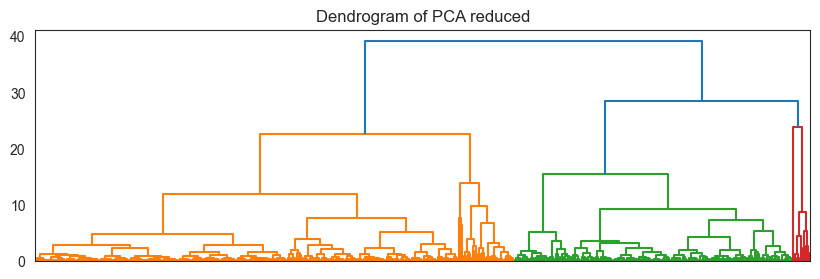

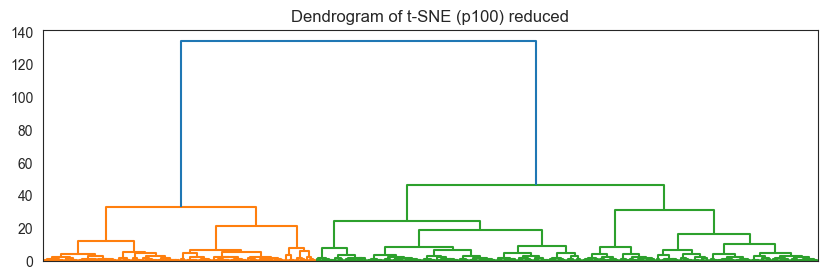

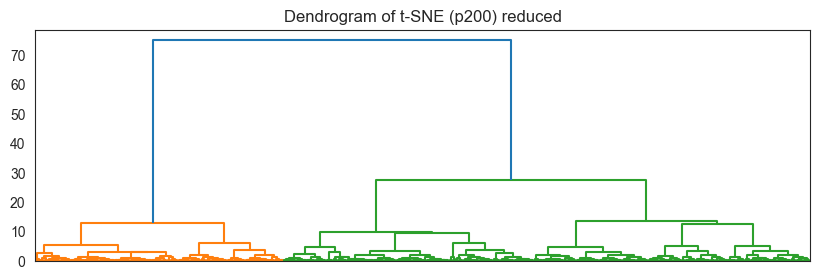

In [17]:
# visualize the dendrograms based on hiearchical clustering
hclust_pca = linkage(pca_X_final, 'ward')
hclust_tsne_p100 = linkage(tsne_X_scaled_p100, 'ward')
hclust_tsne_p200 = linkage(tsne_X_scaled_p200, 'ward')

sns.set_style(style='white')
plt.figure(figsize=(10,3))
dn = dendrogram(hclust_pca)
plt.title("Dendrogram of PCA reduced")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.figure(figsize=(10,3))
dn = dendrogram(hclust_tsne_p100)
plt.title("Dendrogram of t-SNE (p100) reduced")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.figure(figsize=(10,3))
dn = dendrogram(hclust_tsne_p200)
plt.title("Dendrogram of t-SNE (p200) reduced")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

## Determine optimal clusters with Silhouette method 

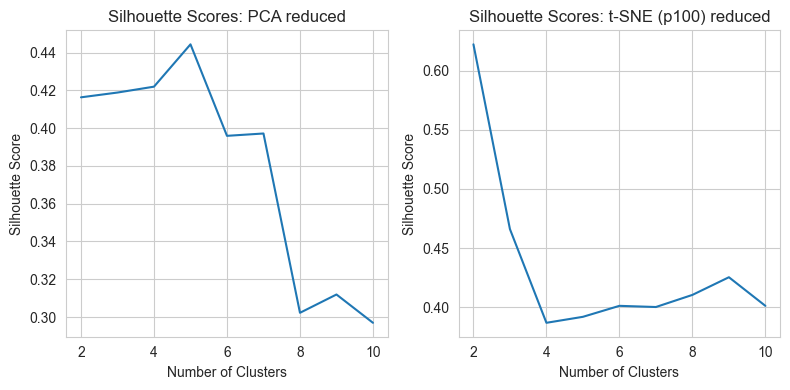

Best k for PCA data =  5 ; Silhouette Score:  0.444
Best k for t-SNE (p100) data =  2 ; Silhouette Score:  0.623


In [15]:
ss_pca = []; ss_tsne = []; kmax = 10

# choose top 3 components as it represents > 75% of variance
pca_X_final = pca_X.iloc[:,:3]

for k in range(2, kmax + 1):
    Aggc = AgglomerativeClustering(n_clusters = k, affinity = 'euclidean', linkage = 'ward').fit(pca_X_final)
    labels = Aggc.labels_
    ss_pca.append(silhouette_score(pca_X_final, labels, metric = 'euclidean'))

    Aggc = AgglomerativeClustering(n_clusters = k, affinity = 'euclidean', linkage = 'ward').fit(tsne_X_scaled_p100)
    labels = Aggc.labels_
    ss_tsne.append(silhouette_score(tsne_X_scaled_p100, labels, metric = 'euclidean'))

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax = axes[0]
sns.lineplot(x = range(2,kmax + 1), y = ss_pca, ax=ax)
ax.set_title('Silhouette Scores: PCA reduced')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Silhouette Score")

ax = axes[1]
sns.lineplot(x = range(2,kmax + 1), y = ss_tsne, ax=ax)
ax.set_title('Silhouette Scores: t-SNE (p100) reduced') # p100 should have similar number of clusters
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Silhouette Score")

plt.tight_layout()
plt.show()

k_pca = ss_pca.index(max(ss_pca)) + 2
print("Best k for PCA data = ", k_pca, "; Silhouette Score: ", round(max(ss_pca), 3))

k_tsne = ss_tsne.index(max(ss_tsne)) + 2
print("Best k for t-SNE (p100) data = ", k_tsne, "; Silhouette Score: ", round(max(ss_tsne), 3))

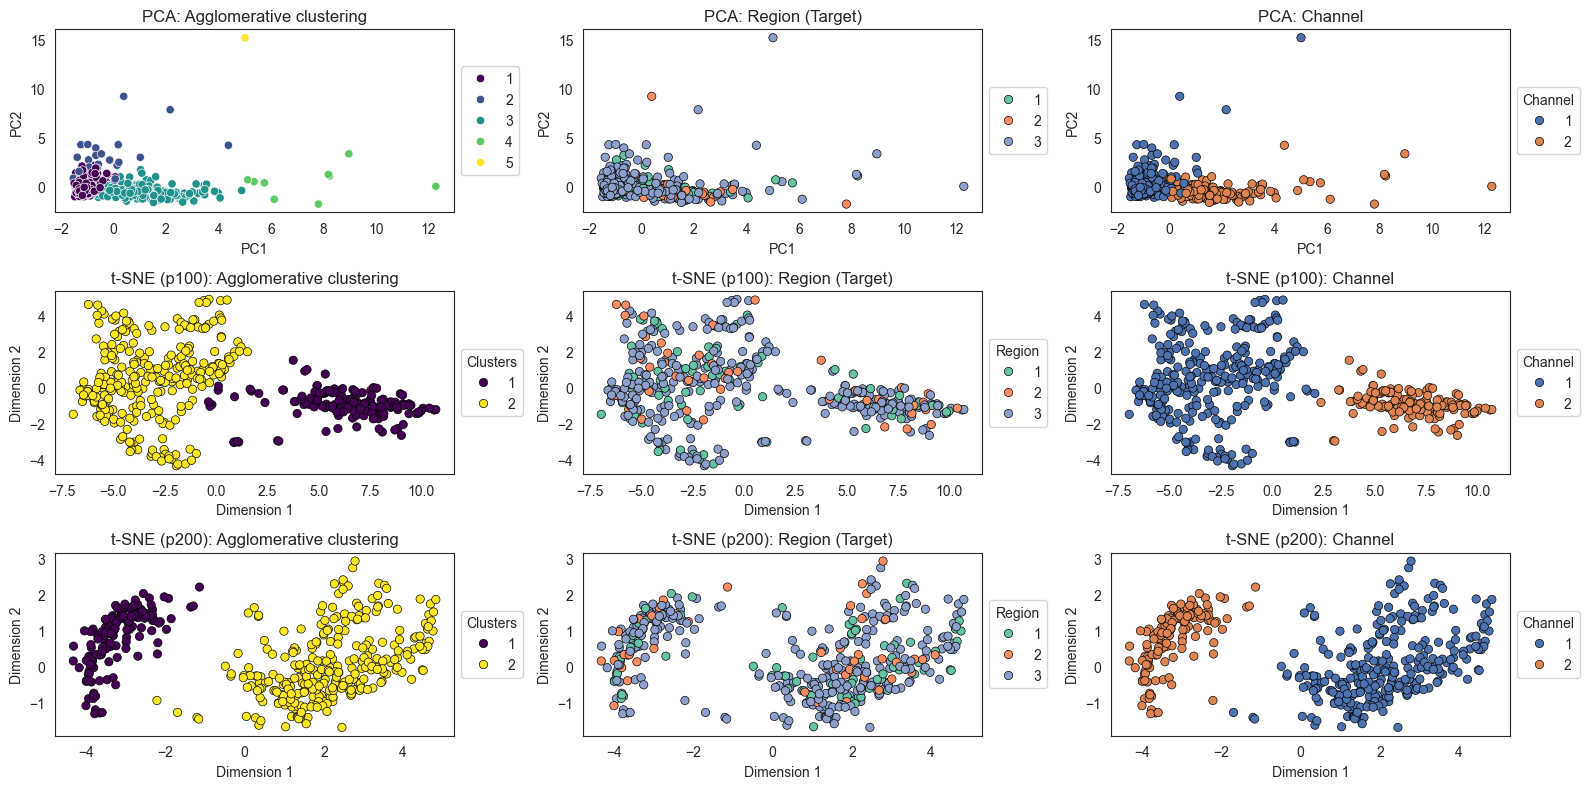

In [18]:
clusters_pca = fcluster(hclust_pca, k_pca, criterion='maxclust')
clusters_tsne_p100 = fcluster(hclust_tsne_p100, k_tsne, criterion='maxclust')
clusters_tsne_p200 = fcluster(hclust_tsne_p200, k_tsne, criterion='maxclust')
                           
fig, axes = plt.subplots(3, 3, figsize=(16, 8))

ax = axes[0,0]
sns.scatterplot(pca_X_final, x="PC1", y="PC2", hue=clusters_pca, palette='viridis', ax=ax)
ax.set_title('PCA: Agglomerative clustering')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax = axes[0,1]
sns.scatterplot(pca_X_final, x="PC1", y="PC2", hue = y.squeeze(), palette='Set2', edgecolor = 'black', ax=ax)
ax.set_title('PCA: Region (Target)')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax = axes[0,2]
sns.scatterplot(pca_X_final, x="PC1", y="PC2", hue = X['Channel'], palette="deep", edgecolor='black', ax=ax)
ax.set_title('PCA: Channel')
ax.legend(title = 'Channel', loc='center left', bbox_to_anchor=(1, 0.5))

ax = axes[1,0]
sns.scatterplot(tsne_X_scaled_p100, x="Dim1", y="Dim2", hue=clusters_tsne_p100, palette='viridis', edgecolor = 'black', ax=ax)
ax.set_title('t-SNE (p100): Agglomerative clustering')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.legend(title = 'Clusters', loc='center left', bbox_to_anchor=(1, 0.5))

ax = axes[1,1]
sns.scatterplot(tsne_X_scaled_p100, x="Dim1", y="Dim2", hue=y.squeeze(), palette='Set2', edgecolor = 'black', ax=ax)
ax.set_title('t-SNE (p100): Region (Target)')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.legend(title = 'Region', loc='center left', bbox_to_anchor=(1, 0.5))

ax = axes[1,2]
sns.scatterplot(tsne_X_scaled_p100, x="Dim1", y="Dim2", hue=X['Channel'], palette='deep', edgecolor = 'black', ax=ax)
ax.set_title('t-SNE (p100): Channel')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.legend(title = 'Channel', loc='center left', bbox_to_anchor=(1, 0.5))

ax = axes[2,0]
sns.scatterplot(tsne_X_scaled_p200, x="Dim1", y="Dim2", hue=clusters_tsne_p200, palette='viridis', edgecolor = 'black', ax=ax)
ax.set_title('t-SNE (p200): Agglomerative clustering')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.legend(title = 'Clusters', loc='center left', bbox_to_anchor=(1, 0.5))

ax = axes[2,1]
sns.scatterplot(tsne_X_scaled_p200, x="Dim1", y="Dim2", hue=y.squeeze(), palette='Set2', edgecolor = 'black', ax=ax)
ax.set_title('t-SNE (p200): Region (Target)')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.legend(title = 'Region', loc='center left', bbox_to_anchor=(1, 0.5))

ax = axes[2,2]
sns.scatterplot(tsne_X_scaled_p200, x="Dim1", y="Dim2", hue=X['Channel'], palette='deep', edgecolor = 'black', ax=ax)
ax.set_title('t-SNE (p200): Channel')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.legend(title = 'Channel', loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

- Agglomerative clustering on PCA reduced data performs poorly, with a cluster containing only a single data point
- Agglomerative clustering on t-SNE reduced data is better, with more misclassified points in p100 than p200 (unlike K-means)

# Clustering method: DBScan

The DBSCAN algorithm uses two parameters:  

minPts: The minimum number of points (a threshold) clustered together for a region to be considered dense. As a rule of thumb, minPts = 2·dim can be used.  
eps (ε): A distance measure that will be used to locate the points in the neighborhood of any point. Value chosen by using a k-distance graph, plotting the distance to the k = minPts-1 nearest neighbor ordered from the largest to the smallest value. Good values of ε are where this plot shows an “elbow”: if ε is chosen much too small, a large part of the data will not be clustered; whereas for a too high value of ε, clusters will merge and the majority of objects will be in the same cluster. In general, small values of ε are preferable, and as a rule of thumb, only a small fraction of points should be within this distance of each other.  

In [19]:
min_samples_pca = 2*len(pca_X_final.columns)
print('min_samples for pca data: ', min_samples_pca)
NN_pca = min_samples_pca - 1
print('Nearest neighbours for pca data: ', NN_pca)

min_samples_tsne = 2*len(tsne_X_scaled_p100.columns)
print('min_samples for tsne data: ', min_samples_tsne)
NN_tsne = min_samples_tsne - 1
print('Nearest neighbours for tsne data: ', NN_tsne)

min_samples for pca data:  6
Nearest neighbours for pca data:  5
min_samples for tsne data:  4
Nearest neighbours for tsne data:  3


## k-distance graph

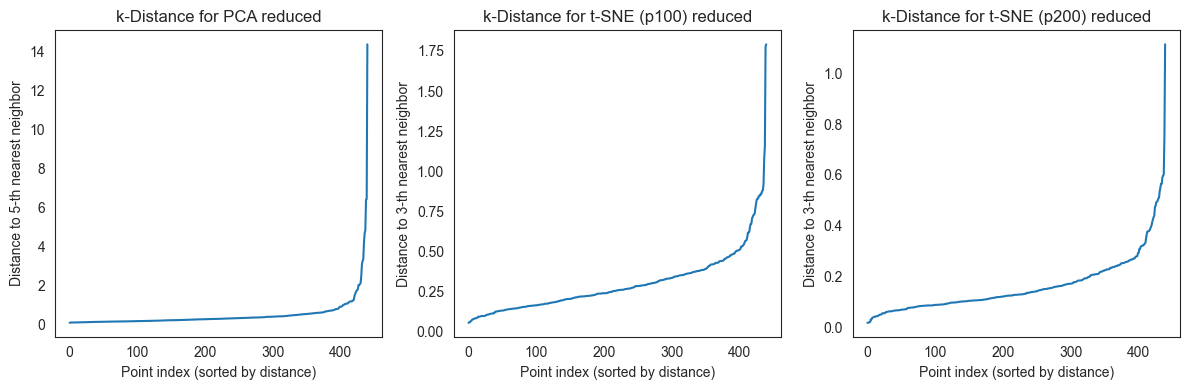

In [20]:
# distance to the k-th nearest neighbor
neigh = NearestNeighbors(n_neighbors=NN_pca)
neigh.fit(pca_X_final)
distances, indices = neigh.kneighbors(pca_X_final)
sorted_distances = np.sort(distances[:, NN_pca-1], axis=0)

pca_k_distance = pd.DataFrame({
    'Point Index': range(len(sorted_distances)),
    f'Distance to {NN_pca}-th Nearest Neighbor': sorted_distances
})

neigh = NearestNeighbors(n_neighbors=NN_tsne)
neigh.fit(tsne_X_scaled_p100)
distances, indices = neigh.kneighbors(tsne_X_scaled_p100)
sorted_distances = np.sort(distances[:, NN_tsne-1], axis=0)

tsne_p100_k_distance = pd.DataFrame({
    'Point Index': range(len(sorted_distances)),
    f'Distance to {NN_tsne}-th Nearest Neighbor': sorted_distances
})

neigh = NearestNeighbors(n_neighbors=NN_tsne)
neigh.fit(tsne_X_scaled_p200)
distances, indices = neigh.kneighbors(tsne_X_scaled_p200)
sorted_distances = np.sort(distances[:, NN_tsne-1], axis=0)

tsne_p200_k_distance = pd.DataFrame({
    'Point Index': range(len(sorted_distances)),
    f'Distance to {NN_tsne}-th Nearest Neighbor': sorted_distances
})

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ax = axes[0]
sns.lineplot(data=pca_k_distance, x='Point Index', y=f'Distance to {NN_pca}-th Nearest Neighbor', ax=ax)
ax.set_title('k-Distance for PCA reduced')
ax.set_xlabel('Point index (sorted by distance)')
ax.set_ylabel(f'Distance to {NN_pca}-th nearest neighbor')

ax = axes[1]
sns.lineplot(data=tsne_p100_k_distance, x='Point Index', y=f'Distance to {NN_tsne}-th Nearest Neighbor', ax=ax)
ax.set_title('k-Distance for t-SNE (p100) reduced')
ax.set_xlabel('Point index (sorted by distance)')
ax.set_ylabel(f'Distance to {NN_tsne}-th nearest neighbor')

ax = axes[2]
sns.lineplot(data=tsne_p200_k_distance, x='Point Index', y=f'Distance to {NN_tsne}-th Nearest Neighbor', ax=ax)
ax.set_title('k-Distance for t-SNE (p200) reduced')
ax.set_xlabel('Point index (sorted by distance)')
ax.set_ylabel(f'Distance to {NN_tsne}-th nearest neighbor')

plt.tight_layout()
plt.show()

- for pca reduced data, the epsilon value is ~ 1
- for t-SNE p100 reduced data, the epsilon value is ~ 0.55
- for t-SNE p200 reduced data, the epsilon value is ~ 0.3

In [21]:
def optimise_dbscan_params(data, min_samples, eps):
    
    data = data 
    # parameters for epsilon and min_samples
    eps_range = np.linspace(eps, 4, 10)
    min_samples_range = range(min_samples, 10) 
    
    results = []
    
    for eps in eps_range:
        for min_samples in min_samples_range:
            model = DBSCAN(eps=eps, min_samples=min_samples)
            labels = model.fit_predict(data)

            core_samples_mask = np.zeros_like(model.labels_, dtype=bool)
            core_samples_mask[model.core_sample_indices_] = True
            
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_outliers = list(labels).count(-1)
            
            if 1 < n_clusters < len(data) - 1:
                silhouette_avg = silhouette_score(data, labels)
                n_outliers = np.sum(labels == -1)
                outliers_percent = n_outliers / len(data) * 100            
                
                results.append({
                    'eps': eps,
                    'min_samples': min_samples,
                    'silhouette_score': silhouette_avg,
                    'number_of_clusters': n_clusters,
                    'number_of_outliers': n_outliers,
                    'outliers_percent': outliers_percent,
                })
        
    results_df = pd.DataFrame(results)
    return(results_df)

In [22]:
pca_res=optimise_dbscan_params(pca_X_final, min_samples=2, eps = 1)
tsne_p100_res=optimise_dbscan_params(tsne_X_scaled_p100, min_samples=min_samples_tsne, eps = 0.55)
tsne_p200_res=optimise_dbscan_params(tsne_X_scaled_p200, min_samples=min_samples_tsne, eps = 0.3)
print("PCA:")
display(pca_res.sort_values(by='silhouette_score', ascending=False).head(3))
print("tSNE p100:")
display(tsne_p100_res.sort_values(by='silhouette_score', ascending=False).head(6))
print("tSNE p200:")
display(tsne_p200_res.sort_values(by='silhouette_score', ascending=False).head(3))

PCA:


,eps,min_samples,silhouette_score,number_of_clusters,number_of_outliers,outliers_percent
4,2.33,2,0.73,2,5,1.14
5,2.33,3,0.73,2,5,1.14
6,2.67,2,0.73,2,5,1.14


tSNE p100:


,eps,min_samples,silhouette_score,number_of_clusters,number_of_outliers,outliers_percent
10,0.93,8,0.45,2,21,4.77
9,0.93,7,0.44,2,18,4.09
13,1.32,8,0.43,2,7,1.59
14,1.32,9,0.43,2,7,1.59
8,0.93,6,0.42,2,13,2.95
6,0.93,4,0.36,3,2,0.45


tSNE p200:


,eps,min_samples,silhouette_score,number_of_clusters,number_of_outliers,outliers_percent
17,1.12,9,0.51,2,4,0.91
16,1.12,8,0.51,2,4,0.91
15,1.12,7,0.51,2,4,0.91


[-1, 0, 1]


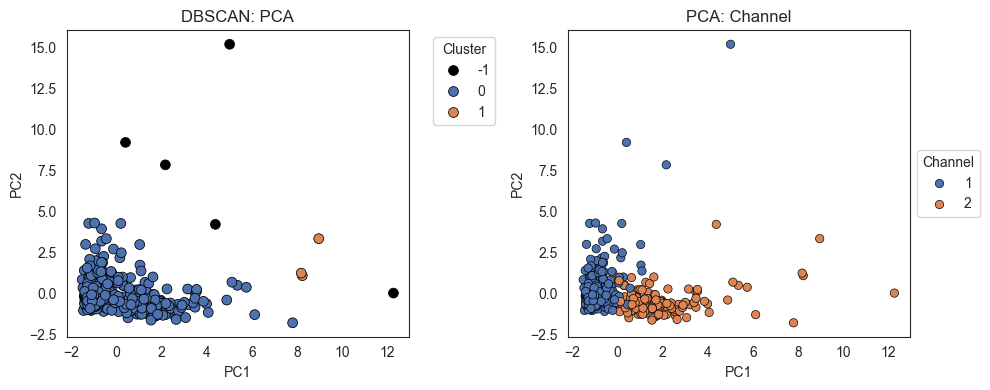

In [23]:
X_dbscan = pca_X_final

optimal_model = DBSCAN(eps=2.33, min_samples=3)
optimal_labels = optimal_model.fit_predict(X_dbscan)

X_dbscan['Cluster'] = optimal_labels

unique_clusters = sorted(X_dbscan['Cluster'].unique())
print(unique_clusters)
# palette = dict(zip(unique_clusters,  sns.color_palette("deep")))
palette = {cluster: "black" if cluster == -1 else color for cluster, color in zip(unique_clusters, ["black"] + sns.color_palette("deep").as_hex())}

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
sns.scatterplot(data=X_dbscan, x='PC1', y='PC2', hue='Cluster', palette=palette, edgecolor='k', s=50, ax=ax)
ax.set_title('DBSCAN: PCA')
ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

ax = axes[1]
sns.scatterplot(X_dbscan, x="PC1", y="PC2", hue=X['Channel'], palette='deep', edgecolor = 'black', ax=ax)
ax.set_title('PCA: Channel')
ax.legend(title = 'Channel', loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

[-1, 0]


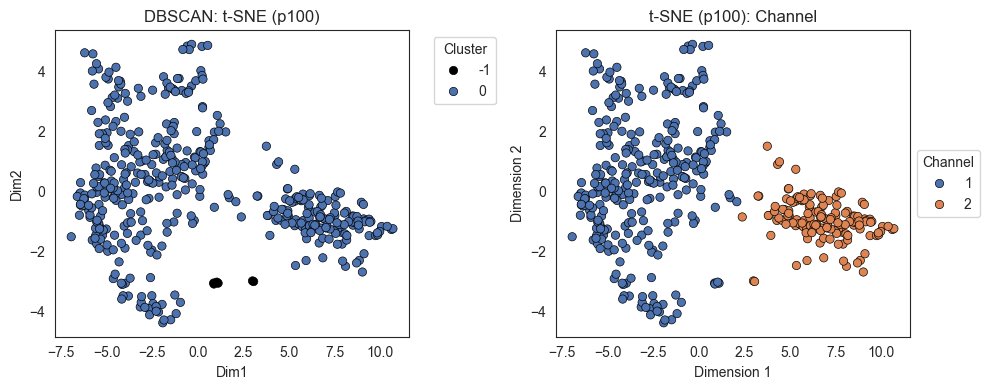

In [24]:
X_dbscan = tsne_X_scaled_p100

optimal_model = DBSCAN(eps=1.32, min_samples=7)
optimal_labels = optimal_model.fit_predict(X_dbscan)
optimal_labels

X_dbscan['Cluster'] = optimal_labels

unique_clusters = sorted(X_dbscan['Cluster'].unique())
print(unique_clusters)
# palette = dict(zip(unique_clusters,  sns.color_palette("deep")))
palette = {cluster: "black" if cluster == -1 else color for cluster, color in zip(unique_clusters, ["black"] + sns.color_palette("deep").as_hex())}

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
sns.scatterplot(data=X_dbscan, x='Dim1', y='Dim2', hue='Cluster', palette=palette, edgecolor='k', ax=ax)
ax.set_title('DBSCAN: t-SNE (p100)')
ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

ax = axes[1]
sns.scatterplot(X_dbscan, x="Dim1", y="Dim2", hue=X['Channel'], palette='deep', edgecolor = 'black', ax=ax)
ax.set_title('t-SNE (p100): Channel')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.legend(title = 'Channel', loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

[-1, 0, 1]


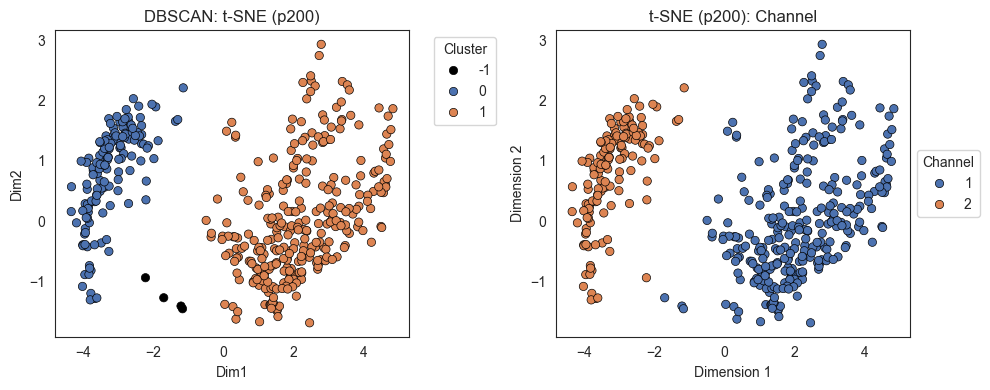

In [25]:
X_dbscan = tsne_X_scaled_p200

optimal_model = DBSCAN(eps=1.12, min_samples=7)
optimal_labels = optimal_model.fit_predict(X_dbscan)
optimal_labels

X_dbscan['Cluster'] = optimal_labels


unique_clusters = sorted(X_dbscan['Cluster'].unique())
print(unique_clusters)
# palette = dict(zip(unique_clusters,  sns.color_palette("deep")))
palette = {cluster: "black" if cluster == -1 else color for cluster, color in zip(unique_clusters, ["black"] + sns.color_palette("deep").as_hex())}

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
sns.scatterplot(data=X_dbscan, x='Dim1', y='Dim2', hue='Cluster', palette=palette, edgecolor='k', ax=ax)
ax.set_title('DBSCAN: t-SNE (p200)')
ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

ax = axes[1]
sns.scatterplot(X_dbscan, x="Dim1", y="Dim2", hue=X['Channel'], palette='deep', edgecolor = 'black', ax=ax)
ax.set_title('t-SNE (p200): Channel')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.legend(title = 'Channel', loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

- DBScan clustering works best on t-SNE (p100) reduced data and is worse on PCA reduced data
- t-SNE (p100) DBScan params: eps=1.7, min_samples=8

# Summary
- The features provided in this dataset seem to be insufficient for clustering on Region, therefore clustering methods chosen would be based on Channel.
- None of the clustering methods worked well on the PCA reduced data. It is likely that linear dimensionality reduction methods failed to capture most of the relationships between the features.
- PCA-reduced data resulted in small tight clusters in close proximity. Therefore, for clustering methods such as K-means and DBScan, the further points failed to be included in a cluster.
- t-SNE preserves nearest neighbours but not distance information, and hence should not be used with density or distance-based clustering methods such as K-means or DBScan. However, for this dataset, it seems to work well as the clusters coincide with underlying Channel features

  
Best transformed data to use for each clustering method: 
- K-means clustering: t-SNE reduced data with 100 perplexity
- Agglomerative clustering: t-SNE reduced data with 200 perplexity
- DBScan: t-SNE reduced data with 100 perplexity

Best clustering method:
- Agglomerative clustering: t-SNE reduced data with 200 perplexity (with 1 misclassification)

To do: perform clustering methods on original data set?

# References
- https://stats.stackexchange.com/questions/263539/clustering-on-the-output-of-t-sne/352138#352138
- https://www.kaggle.com/code/kashnitsky/topic-7-unsupervised-learning-pca-and-clustering
- TS's notebook